<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Flensing/notebooks/dev/LensingForwardModelLogNormal_NPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet lenstools
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git 
!pip install --quiet numpyro
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

In [2]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())


In [3]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from sbids.tasks import get_samples_and_scores


Populating the interactive namespace from numpy and matplotlib


In [4]:
!pip install --quiet jax-cosmo numpyro dm-haiku==0.0.5 optax

In [5]:
import os
import argparse
import pickle
from functools import partial

import optax
import haiku as hk
import numpy as np
import jax
import jax.numpy as jnp
from numpyro.handlers import condition

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions


from sbids.metrics.c2st import c2st
from sbids.tasks import (
  lotka_volterra, lotka_volterra_y_bijector, 
  lotka_volterra_theta_bijector, get_samples_and_scores
)
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [6]:
from numpyro.handlers import seed, trace, condition, substitute
import jax


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
  k = 2*jnp.pi*jnp.fft.fftfreq(N, d=field_size / N)
  kcoords = jnp.meshgrid(k,k)
  k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
  ps_map = pk_fn(k)
  ps_map = ps_map.at[0,0].set(zero_freq_val)
  return ps_map * (N / field_size)**2

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
  power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
  power_spectrum_for_lognorm = jnp.log(1 + power_spectrum_for_lognorm/shift**2)
  power_spectrum_for_lognorm = jnp.abs(jnp.fft.fft2(power_spectrum_for_lognorm))
  power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0,0].set(0.)
  return power_spectrum_for_lognorm

def model(N=128,               # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=10,   
          sigma_e=0.2, 
          shift=0.05,
          model_type='lognormal'): # either 'lognormal' or 'gaussian'      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians

    # Sampling cosmology
    # omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05)) #* 0.05 + 0.3
    # sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05)) #* 0.05 + 0.8

    theta = numpyro.sample('theta', dist.Independent(dist.Normal(jnp.array([0.3,0.8]), 0.05*jnp.ones(2)),1))
    
    cosmo = jc.Planck15(Omega_c=theta[0], sigma8=theta[1])
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    # Sampling latent variables
    z = numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((N,N)), precision_matrix=jnp.eye(N)))

    # Convolving by the power spectrum
    power_map = make_power_map(P, N, map_size) 
    if model_type == 'lognormal':
      power_map =  make_lognormal_power_map(power_map, shift)

    field = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real

    if model_type == 'lognormal':
      field = shift * (jnp.exp(field - jnp.var(field) / 2) - 1)

    # Adding "observational noise"
    y = numpyro.sample('y', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return y

In [7]:
@jax.jit
def get_batch(key, batch_size=10):
    (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size)
    return samples['theta'], samples['y'], scores

In [9]:
master_key = jax.random.PRNGKey(45)
master_key, keys = jax.random.split(master_key)

mu, sim, score = get_batch(key = keys)
for i in range(1,3000):
  master_key, keys = jax.random.split(master_key)
  mu_t, sim_t, score_t = get_batch(key = keys)
  mu = jnp.concatenate([mu, mu_t])
  sim = jnp.concatenate([sim, sim_t])
  score = jnp.concatenate([score, score_t])

/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

In [10]:
score = jnp.load('/content/score.npy')
sim = jnp.load('/content/sim.npy')
mu = jnp.load('/content/mu.npy')

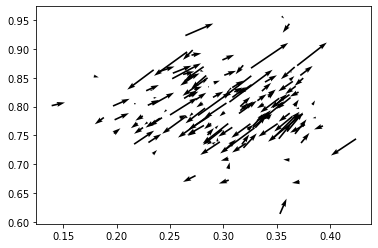

In [11]:
quiver(mu[::200,0], mu[::200,1], score[::200,0], score[::200,1])

In [12]:
class Compressor(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x):
    x = x[..., jnp.newaxis]
    net_x = hk.Conv2D(32, 3, 2)(x) # in 32
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.Conv2D(64, 3, 2)(net_x) # in 16
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.Conv2D(128, 3, 2)(net_x)# in 8
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.AvgPool(16,8,'SAME')(net_x) # in 2
    net_x = hk.Flatten()(net_x)

    # Bottleneck
    net_x = hk.Linear(2)(net_x)

    return net_x.squeeze()

In [13]:
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
rng_seq = hk.PRNGSequence(12)
params_compressor = compressor.init(next(rng_seq), jnp.zeros([1,128,128]))

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [14]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_compressor)

In [15]:
def loss_fn(params, batch):
  out = jax.vmap(lambda p, x: compressor.apply(params, x.reshape([-1,128,128])))(*batch) # Here we extract the grad of the model
  return jnp.mean(jnp.sum((out - batch[0])**2, axis=1))

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [16]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

In [17]:
it = 1000

for step in tqdm(range(it)):
  inds = np.random.randint(0, len(score), 256) 
  l, params_compressor, opt_state = update(params_compressor, opt_state, (mu[inds], sim[inds]))
  losses.append(l)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
100%|██████████| 1000/1000 [00:27<00:00, 36.35it/s]


In [18]:
learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_compressor)

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [19]:
it = 20000

for step in tqdm(range(it)):
  inds = np.random.randint(0, len(score), 256) 
  l, params_compressor, opt_state = update(params_compressor, opt_state, (mu[inds], sim[inds]))
  losses.append(l)

100%|██████████| 20000/20000 [08:38<00:00, 38.61it/s]


In [22]:
with open("params_compressor.pkl", "wb") as fp:
  pickle.dump(params_compressor, fp)

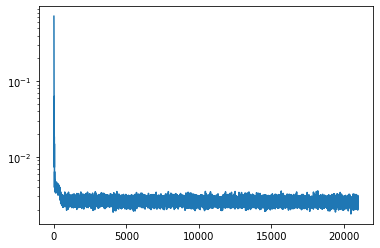

In [23]:
semilogy(array(losses))

In [20]:
jnp.where(jnp.isnan(sim))

(DeviceArray([], dtype=int32),
 DeviceArray([], dtype=int32),
 DeviceArray([], dtype=int32))

In [21]:
sim.shape

(30000, 128, 128)

In [24]:
reg = compressor.apply(params_compressor, sim[:5000])

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


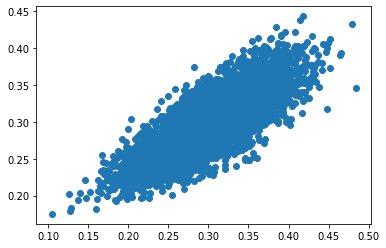

In [26]:
scatter(mu[:5000,0], reg[:,0])

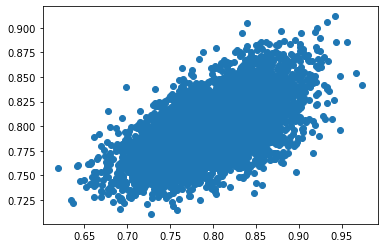

In [27]:
scatter(mu[:5000,1], reg[:,1])

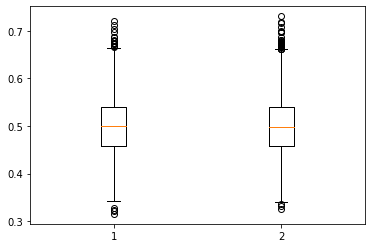

In [28]:
scale_reg = jnp.array(jnp.std(reg, axis =0)/0.06)
shift_reg = jnp.mean(reg/scale_reg, axis = 0)-0.5

data = reg/scale_reg - shift_reg
plt.clf()
plt.boxplot([data[...,0],data[...,1]]);

In [29]:
print(scale_reg)
print(shift_reg)

[0.6626663 0.4956362]
[-0.05086133  1.109291  ]


In [30]:
scale_theta = jnp.array(jnp.std(mu, axis =0)/0.05)
shift_theta = jnp.mean(mu/scale_theta, axis = 0)-0.5

In [31]:
print(scale_theta)
print(shift_theta)

[1.0082474 1.0003674]
[-0.20237258  0.29989904]


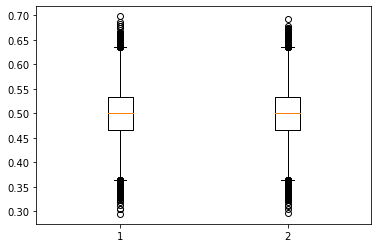

In [32]:
data = mu/scale_theta - shift_theta
plt.clf()
plt.boxplot([data[...,0],data[...,1]]);

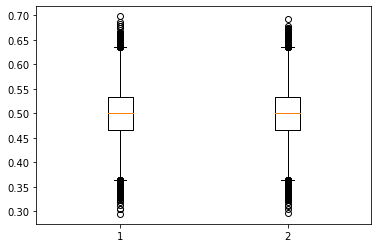

In [33]:
trasfo_params = tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
normalized_p = trasfo_params.inverse(mu)
plt.boxplot([normalized_p[...,0],normalized_p[...,1]]);

In [34]:
# create model 
from functools import partial
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)


NF_npe = partial(
  ConditionalRealNVP,
  n_layers=4, 
  bijector_fn=bijector_npe)


class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y/scale_reg - shift_reg
        nvp = NF_npe(2)(net)
        result = tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(tfb.Scale(scale_theta),
                                                      tfb.Shift(shift_theta))]))
        return result


nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))

# init parameters
params_nd = nvp_nd.init(next(rng_seq),  0.5*jnp.zeros([1,2]), 0.5*jnp.zeros([1,2]))

# init optimizer
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_nd)

# define loss function and model update
def loss_fn(params, weight, mu, batch, score):
  y = compressor.apply(params_compressor, batch)
  log_prob, out = jax.vmap(
    jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,2]), x.reshape([1,2])).squeeze())
    )(mu, y)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 

@jax.jit
def update(params, opt_state, weight, mu, batch,score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch,score)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [36]:
master_key = jax.random.PRNGKey(450)
master_key, keys = jax.random.split(master_key)

mu, sim, score = get_batch(key = keys)
for i in range(1,3000):
  master_key, keys = jax.random.split(master_key)
  mu_t, sim_t, score_t = get_batch(key = keys)
  mu = jnp.concatenate([mu, mu_t])
  sim = jnp.concatenate([sim, sim_t])
  score = jnp.concatenate([score, score_t])

In [35]:
# train
batch_loss = []
for step in tqdm(range(1000)):
    inds = np.random.randint(0, len(score), 256) 
    l, params_nd, opt_state = update(params_nd, opt_state, 0, mu[inds], sim[inds], score[inds])
    if jnp.isnan(l):
      break
    batch_loss.append(l)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


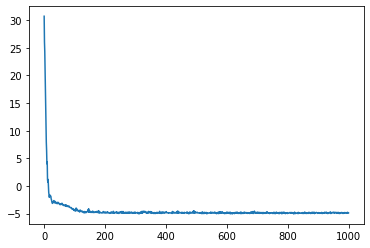

In [36]:
plt.plot(batch_loss)

In [91]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0.3, 'sigma_8': 0.8})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(28))
m_data = sample_map_fiducial()

/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

In [92]:
nvp_sample_nd = hk.transform(lambda x : SmoothNPE()(x).sample(10000, seed=hk.next_rng_key()))
rng_seq = hk.PRNGSequence(19)
y = compressor.apply(params_compressor, m_data.reshape(-1,128,128))
sample_nd2 = nvp_sample_nd.apply(params_nd, 
                                    rng = next(rng_seq), 
                                    x = y*jnp.ones([10000,2]))

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


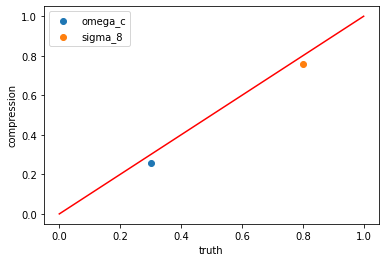

In [93]:
x = jnp.linspace(0,1,100)
plt.plot(x, x, c='red')
plt.scatter(0.3, y[0], label = 'omega_c')
plt.scatter(0.8, y[1], label = 'sigma_8')
plt.xlabel('truth')
plt.ylabel('compression')
plt.legend()

Text(0, 0.5, 'sigma_8')

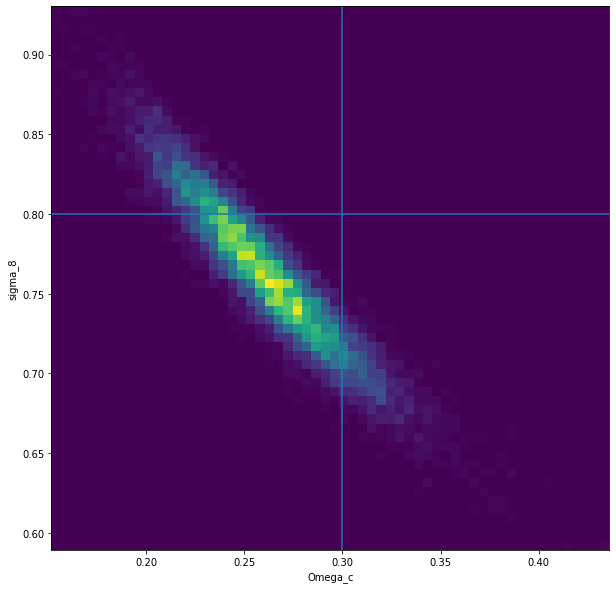

In [94]:
figure(figsize=[10,10])
plt.hist2d(sample_nd2[...,0], sample_nd2[...,1],60);
# scatter(sample_nd[...,0], sample_nd[...,1], c='white',alpha = 0.1);
axvline(0.3)
axhline(0.8)
xlabel('Omega_c')
ylabel('sigma_8')

In [74]:
import pickle 

a_file = open("/content/lensing_fwd_mdl_lognorm-3.pickle", "rb")
sample_pkl = pickle.load(a_file)

In [41]:
sample_nd = jnp.array([sample_pkl['omega_c']* 0.05 + 0.3, sample_pkl['sigma_8']* 0.05 + 0.8]).T

Text(0, 0.5, 'sigma_8')

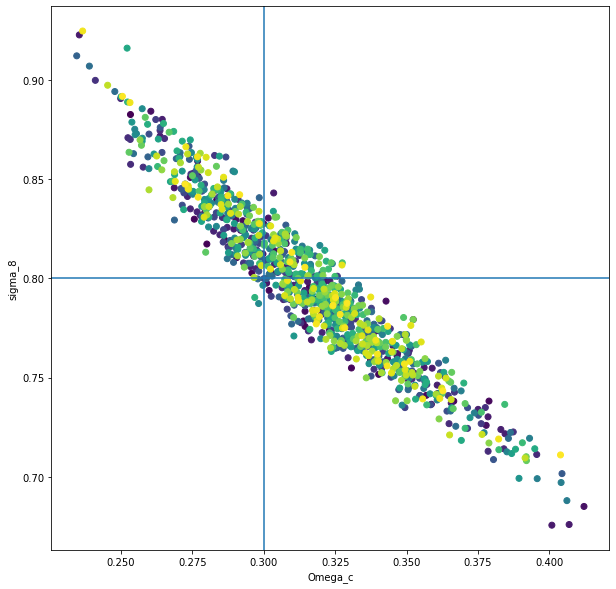

In [42]:
figure(figsize=[10,10])
scatter(sample_nd[...,0], sample_nd[...,1], c=arange(len(sample_pkl['sigma_8'])));
axvline(0.3)
axhline(0.8)
xlabel('Omega_c')
ylabel('sigma_8')